Tutorial 1: Lens and Source
===========================

As discussed in chapter 2, an effective strategy for modeling strong lenses is to break the model-fitting procedure
down into a series of phases, chaining the results of the phases to guide the `NonLinearSearch` as to where to
sample parameter space. In this chapter, we'll cover `Pipeline`'s, which provide a powerful means by which to
chain together many phases.

In chapter 2, we fitted strong lens `Imaging` which included the lens galaxy's light. we're going to fit this dataset
again (I promise, this is the last time!). However, now we're using pipelines, we can perform a different (and
significantly faster) model-fit.

The crucial point to note is that for many lenses the lens galaxy's light can be fitted and subtracted reasonably 
well before we attempt to fit the source galaxy. This makes sense, as fitting the lens's light (which is an elliptical
blob of light in the centre of the imaging) looks nothing like the source's light (which is a ring of light)! Formally,
we would say that these two model components (the lens's light and source's light) are not covariant.

So, as a newly trained lens modeler, what does the lack of covariance between these parameters make you think?
Hopefully, you're thinking, why should I bother fitting the lens and source galaxy simultaneously? Surely we can
find the right regions of non-linear parameter space by fitting each separately first? This is what we're going to do
in this tutorial, using a pipeline composed of a modest 3 phases:

 1) Fit the lens galaxy's light, ignoring the source.
 2) Fit the source-`Galaxy`'s light (and therefore lens galaxy's mass), ignoring the len`s light.
 3) Fit both simultaneously, using these results to initialize our starting location in parameter space.

Of course, given that we do not care for the errors in phases 1 and 2, we will set up our `NonLinearSearch` to perform
sampling as fast as possible!

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


we'll use strong lensing data, where:

 - The lens galaxy's `LightProfile` is an `EllipticalSersic`.
 - The lens galaxy's total mass distribution is an `EllipticalIsothermal`.
 - The source galaxy's `LightProfile` is an `EllipticalExponential`.
 
This image was fitted throughout chapter 2.

In [2]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

We need to choose our mask for the analysis. Given the lens light is present in the image we'll need to include all 
of its light in the central regions of the image, so lets use a circular mask.

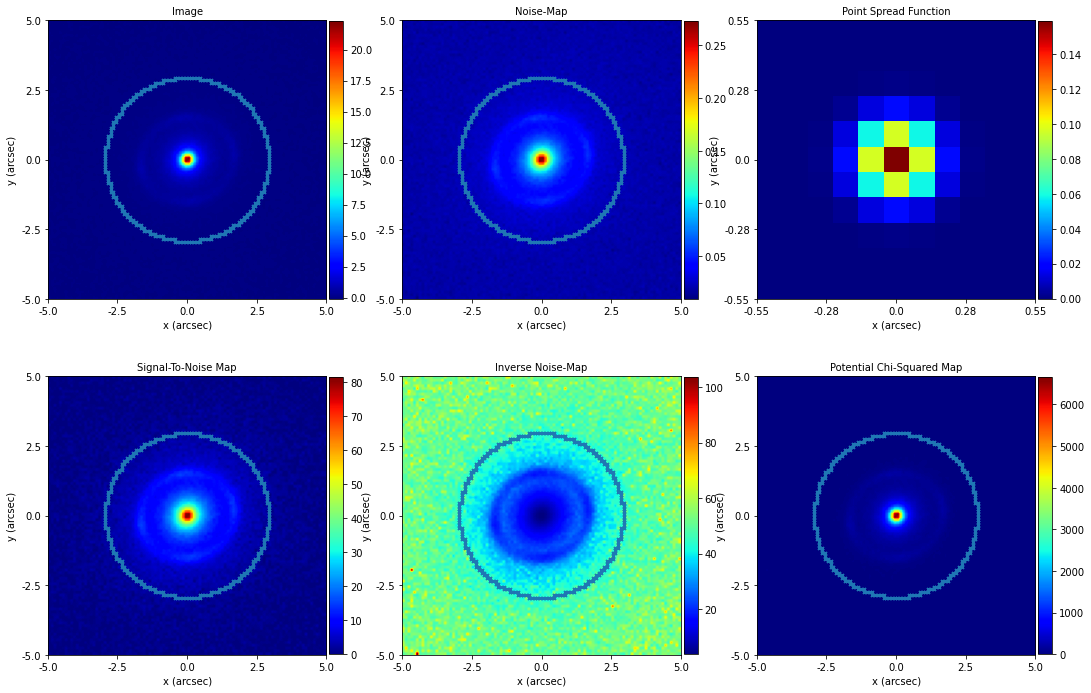

In [3]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

__Settings__

The `SettingsPhaseImaging` describe how the model is fitted to the data in the log likelihood function. We discussed
these in chapter 2, and a full description of all settings can be found in the example script:

 `autolens_workspace/notebooks/modeling/customize/settings.py`.

The settings chosen here are applied to all phases in the pipeline.

In [4]:
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D, sub_size=2)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

__Pipeline Creation__

To create a `Pipeline`, we call a `make_pipeline` function, which is written in its own Python script: 

 `pipelines/tutorial_1_pipeline_lens_and_source.py`. 
    
Before we check it out, lets get the pipeline running, by importing the script, running the `make_pipeline` function
to create the `Pipeline` object and calling that objects `run` function.

In [5]:
from pipelines import tutorial_1_pipeline_lens_and_source

pipeline_lens_and_source = tutorial_1_pipeline_lens_and_source.make_pipeline(
    path_prefix=path.join("howtolens", "c3_t1_lens_and_source"),
    settings=settings,
    redshift_lens=0.5,
    redshift_source=1.0,
)

# Uncomment to run.
# pipeline_lens_and_source.run(dataset=imaging, mask=mask)

Okay, good job, we're running our first pipeline in **PyAutoLens**! But what does it *actually* do? Well, to find 
that out, go to the script `pipelines/tutorial_1_pipeline_lens_and_source.py`, which contains a full description of 
the pipeline, as well as an overview of the tools we use to write the most general pipelines possible. Once you're 
done, come back to this pipeline runner script and we'll wrap up tutorial 1.

And there we have it, a pipeline that breaks the analysis of the lens and source galaxy into 3 simple phases. This 
approach is much faster than fitting the lens and source simultaneously from the beginning. Instead of asking you 
questions at the end of this chapter`s tutorials, I'm gonna give a Q&A - this`ll hopefully get you thinking about how 
to approach pipeline writing.

 1) Can this pipeline really be generalized to any lens? Surely the radii of the mask depends on the lens and source 
 galaxies?

Whilst this is true, we've chosen a mask radii above that is `excessive` and masks out a lot more of the image than 
just the source (which, in terms of run-time, is desirable). Thus, provided you know the Einstein radius distribution 
of your lens sample, you can choose mask radii that will masks out every source in your sample adequately (and even if 
some of the source is still there, who cares? The fit to the lens galaxy will be okay).